RUL 예측 모델은 다음 논문에서 제안하는 모델을 참고하였습니다.   
**[A Novel Time-Series Memory Auto-Encoder With Sequentially Updated Reconstructions for Remaining Useful Life Prediction(2021)](https://ieeexplore.ieee.org/abstract/document/9461165)**  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **1. 라이브러리**

In [ ]:
import os

os.chdir('/content/drive/My Drive/Colab Notebooks/CMAPSSData')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

import warnings
warnings.filterwarnings('ignore')

# **2. 데이터 로드/전처리**

- train set: 100개 units의 run to failure까지의 센서 기록 데이터 (train_FD001.txt)
- test set: 100개 units의 센서 기록 데이터 (test_FD001.txt), 각 unit의 RUL target (RUL_FD001.txt)

In [ ]:
test_RUL = np.loadtxt('RUL_FD001.txt')

In [ ]:
train_1 = np.loadtxt('train_FD001.txt')
test_1 = np.loadtxt('test_FD001.txt')

train_1_df = pd.DataFrame(train_1).iloc[:, 5:26]
test_1_df = pd.DataFrame(test_1).iloc[:, 5:26]

train_1_df = pd.concat([pd.DataFrame(train_1).iloc[:, 0:2], train_1_df], axis = 1)
test_1_df = pd.concat([pd.DataFrame(test_1).iloc[:, 0:2], test_1_df], axis = 1)

for df in [train_1_df, test_1_df]:
    df.columns = ['unit', 'time_in_cycle', 
                  'sensor1','sensor2','sensor3','sensor4','sensor5','sensor6','sensor7',
                  'sensor8','sensor9','sensor10','sensor11','sensor12','sensor13','sensor14',
                  'sensor15','sensor16','sensor17','sensor18','sensor19','sensor20','sensor21']

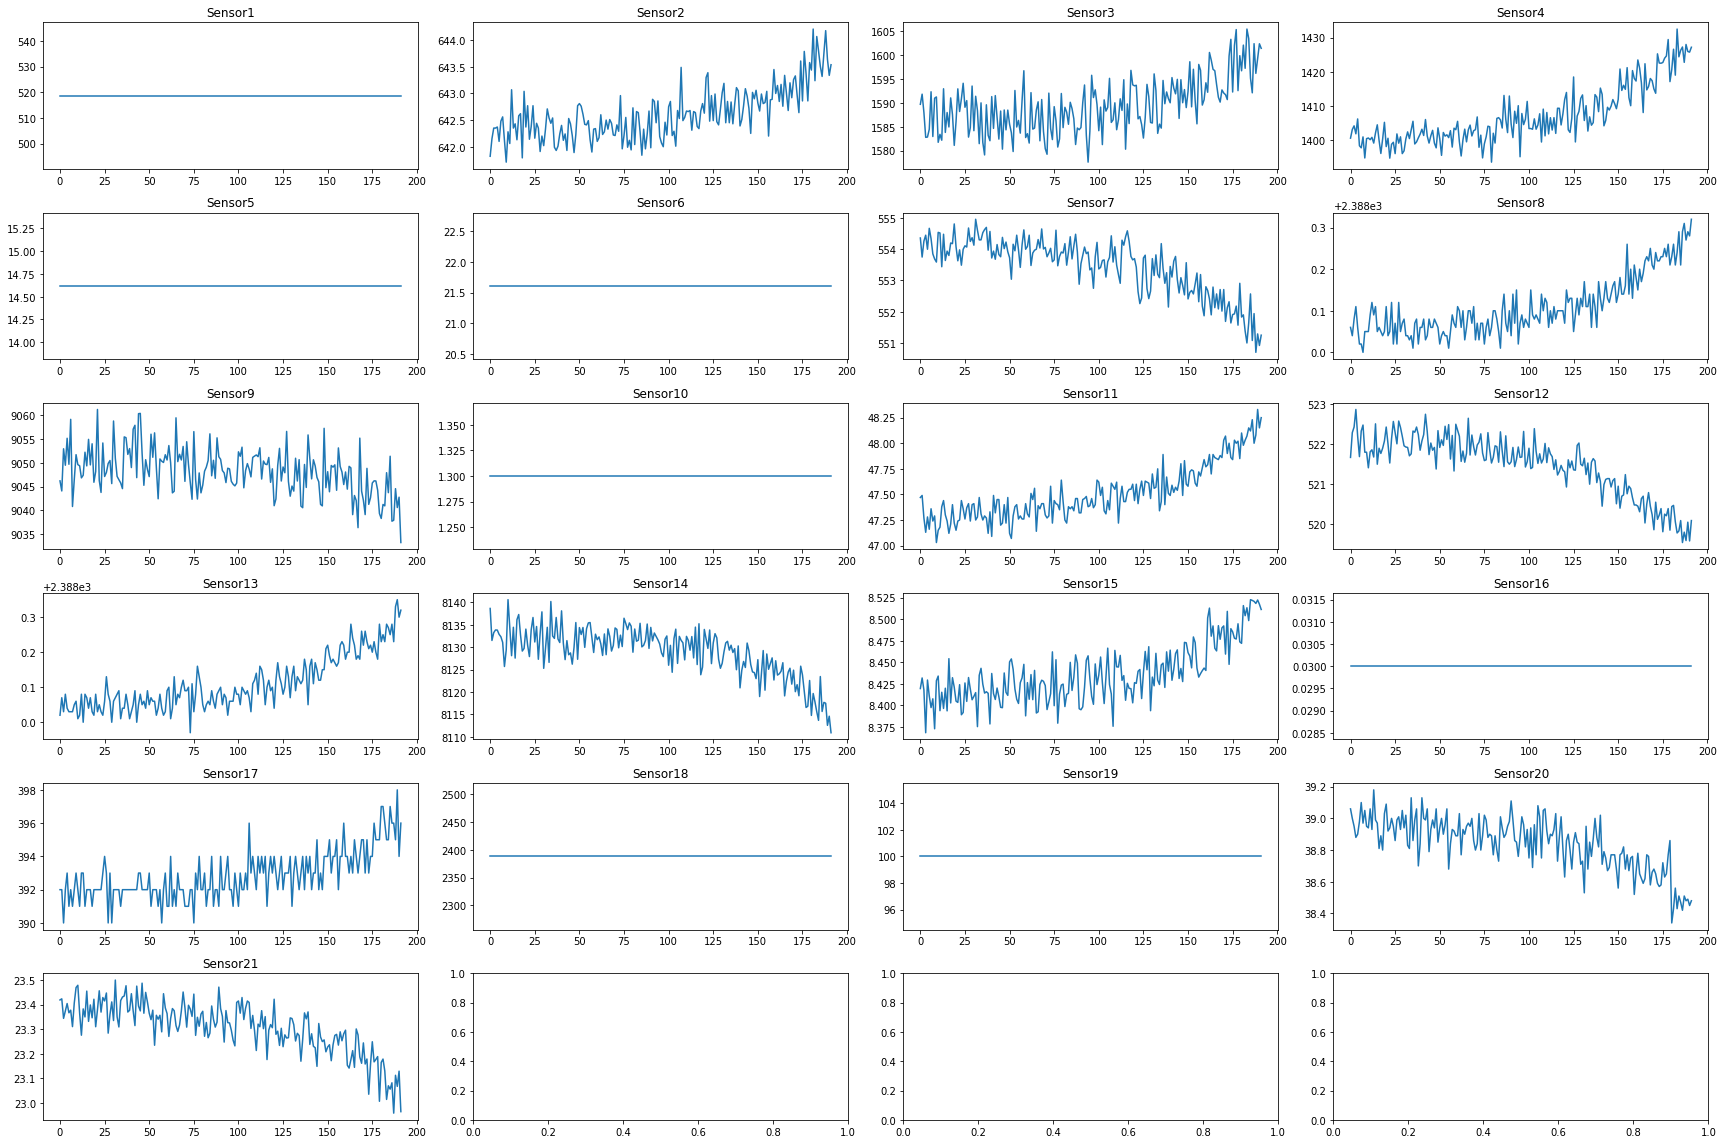

In [ ]:
fig, ax = plt.subplots(figsize=(24, 16), nrows = 6, ncols = 4)

for i in range(21): 
    temp = train_1_df[train_1_df.iloc[:,0] == 1].iloc[:, i+2]
    r = i // 4
    c = i % 4
    ax[r, c].plot(temp)
    ax[r, c].set_title('Sensor{}'.format(i+1))
    
fig.tight_layout()
plt.show()

## **정규화**

In [ ]:
train_1_df_scaled = pd.DataFrame()
test_1_df_scaled = pd.DataFrame()

for i in train_1_df.unit.unique():
    temp_train = train_1_df[train_1_df.unit == i]
    temp_test = test_1_df[test_1_df.unit == i]

    features_train = temp_train[temp_train.columns]
    features_test = temp_test[temp_test.columns]

    temp_scaler = StandardScaler().fit(features_train.values)
    features_train = temp_scaler.transform(features_train.values)
    features_test = temp_scaler.transform(features_test.values)
    
    temp_train[temp_train.columns] = features_train
    temp_test[temp_test.columns] = features_test

    temp_train.unit = i
    temp_test.unit = i

    train_1_df_scaled = pd.concat([train_1_df_scaled, temp_train], axis = 0)
    test_1_df_scaled = pd.concat([test_1_df_scaled, temp_test], axis = 0)

## **슬라이딩 윈도우 처리**

In [ ]:
class windowDataset(Dataset):
    def __init__(self, x_train, input_window, stride=1):
        #총 데이터의 개수
        L = x_train.shape[0]
        # 변수 개수
        V = x_train.shape[1]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window) // stride + 1

        #input: shape = (sample 개수, window 크기)
        X = np.zeros([num_samples, input_window, V])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[i,:,:] = x_train[start_x:end_x]

        self.x = X        
        self.len = len(X)
        
    def __getitem__(self, i):
        return self.x[i]
    
    def __len__(self):
        return self.len

In [ ]:
train_dataset_1 = np.empty((0,20,23), float)

for i in range(1,len(train_1_df_scaled.unit.unique())+1):
    temp = train_1_df_scaled[train_1_df_scaled.unit == i]
    train_dataset_1 = np.append(train_dataset_1, np.array(windowDataset(temp, input_window=20, stride=1)), axis=0)  # 윈도우 사이즈 = 20
    
train_dataset_1.shape  

(18731, 20, 23)

In [ ]:
test_dataset_1 = np.empty((0,20,23), float)

for i in range(1,len(test_1_df_scaled.unit.unique())+1):
    temp = test_1_df_scaled[test_1_df_scaled.unit == i]
    test_dataset_1 = np.append(test_dataset_1, np.array(windowDataset(temp, input_window=20, stride=1)), axis=0)  # 윈도우 사이즈 = 20
    
test_dataset_1.shape  

(11196, 20, 23)

## **불필요 센서 변수 삭제**

In [ ]:
train_dataset_1 = train_dataset_1[:,:,[0,3,4,5,8,9,10,12,13,14,15,16,18,21,22]]  # 센서 번호 2, 3, 4, 7, 8, 9, 11, 12, 13, 14, 15, 17, 20, 21 만 사용
train_dataset_1.shape

(18731, 20, 15)

In [ ]:
test_dataset_1 = test_dataset_1[:,:,[0,3,4,5,8,9,10,12,13,14,15,16,18,21,22]] 
test_dataset_1.shape

(11196, 20, 15)

## **DataLoader**

In [ ]:
train_loader_1 = DataLoader(train_dataset_1[:,:,1:], batch_size=32)  # 데이터 순회 가능한 객체 생성

In [ ]:
test_loader_1 = DataLoader(test_dataset_1, batch_size=1)  # 데이터 순회 가능한 객체 생성

# **3. 모델**

In [ ]:
# 다변량 시계열 데이터를 lstm을 통과시켜 출력된 hidden value로 Context Vector를 생성한다. 
# 이후 2층의 fully connected layers를 통과시켜 1-D HI value를 출력한다. 
class lstm_encoder(nn.Module):
    def __init__(self, n_features, hidden_size, num_layers=2, window_size=20):
        super(lstm_encoder, self).__init__()
        self.input_size = n_features     # 14
        self.hidden_size = hidden_size   # 1
        self.num_layers = num_layers     # 2
        self.window_size = window_size   # 20

        self.lstm = nn.LSTM(input_size = n_features, 
                            hidden_size = hidden_size, 
                            num_layers = num_layers, 
                            batch_first=True)   # input tensor shape: [batch_size, seq_len, input_size]
        self.fc1 = nn.Linear(window_size, 8)
        self.fc2 = nn.Linear(8, 1)
    
    def forward(self, x_input):
        cv, _ = self.lstm(x_input)
        cv = cv.transpose(1,2)  # [32, 20, 1] ->   # [32, 1, 20]
        x = self.fc1(cv) 
        x = F.leaky_relu(x)
        x = self.fc2(x) 
        hi = F.leaky_relu(x)
        return hi, cv  # 1-D HI value, Context Vector

In [ ]:
# 1-D HI value를 입력받아 Context Vector를 재구성한다. 
class decoder(nn.Module):
    def __init__(self, window_size=20):
        super(decoder, self).__init__()
        self.window_size = window_size   # 20
        
        self.fc1 = nn.Linear(1, 8)        
        self.fc2 = nn.Linear(8, window_size)   
        
    def forward(self, x_input):
        x = self.fc1(x_input)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        cv_re = F.leaky_relu(x)
        return cv_re  # reconstructed Context Vector

In [ ]:
class lstm_autoencoder(nn.Module):
    def __init__(self, encoder, decoder, n_features, hidden_size, num_layers=2,  window_size=20):
        super(lstm_autoencoder, self).__init__()
        
        self.n_features = n_features     # 14
        self.hidden_size = hidden_size   # 1
        self.num_layers = num_layers     # 2
        self.window_size = window_size   # 20
        
        self.encoder = encoder(n_features = n_features, hidden_size = hidden_size, num_layers = num_layers, window_size = window_size)
        self.decoder = decoder(window_size = window_size)
        
    def forward(self, x_input):
        hi, cv = self.encoder(x_input)
        cv_re = self.decoder(hi)
        return cv_re, cv, hi  # reconstructed Context Vector, Context Vector, 1-D HI value

# **4. 훈련**

In [ ]:
# 손실 함수는 MAPE를 사용한다. 
def MAPELoss(output, target):
    return torch.mean(torch.abs((target - output) / target))

In [ ]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda' if USE_CUDA else 'cpu')
print(DEVICE)

cuda


## **모델 초기화**

In [ ]:
model = lstm_autoencoder(lstm_encoder, decoder, 14, 1).to(DEVICE)

In [ ]:
learning_rate=0.05
EPOCH = 50
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
def train(model, train_loader):
    model.train()
    total_loss = 0.0

    for step, x in enumerate(train_loader):
        x = x.to(DEVICE).float()
        cv_re, cv, _ = model(x)
        loss = MAPELoss(cv_re, cv)  # 손실 계산
        optimizer.zero_grad()       # 한 번의 역전파가 이루어질 때마다 gradients를 0으로 초기화
        loss.backward()             # 역전파
        optimizer.step()            # 가중치 업데이트
        total_loss += loss.cpu().item()

    print('Train loss: {0:.5f}'.format(total_loss/len(train_loader_1)))
    return total_loss/len(train_loader_1)

In [ ]:
%%time

train_loss = []
best_loss = None

for epoch in range(1, EPOCH+1):
    print('Epoch: {} '.format(epoch), end = ' ')
    loss = train(model, train_loader_1)
    train_loss.append(loss)

    # 손실이 최소화될 때마다 모델 저장
    if not best_loss or loss < best_loss:
        print('Save the best model'.format(epoch))
        torch.save(model.state_dict(), './model/model.pt')
        best_loss = loss
        es = 0
    # 손실이 5epochs 동안 줄어들지 않으면 훈련 조기 중단
    else:
        es += 1
        if es > 4:
            print("Early stopping")
            break

Epoch: 1  Train loss: 0.02498
Save the best model
Epoch: 2  Train loss: 0.01011
Save the best model
Epoch: 3  Train loss: 0.00924
Save the best model
Epoch: 4  Train loss: 0.00811
Save the best model
Epoch: 5  Train loss: 0.00814
Epoch: 6  Train loss: 0.00629
Save the best model
Epoch: 7  Train loss: 0.00544
Save the best model
Epoch: 8  Train loss: 0.00536
Save the best model
Epoch: 9  Train loss: 0.00546
Epoch: 10  Train loss: 0.00529
Save the best model
Epoch: 11  Train loss: 0.00962
Epoch: 12  Train loss: 0.01005
Epoch: 13  Train loss: 0.00796
Epoch: 14  Train loss: 0.00932
Epoch: 15  Train loss: 0.00800
Early stopping
CPU times: user 56.5 s, sys: 1.18 s, total: 57.6 s
Wall time: 57.6 s


## **Loss Curve**

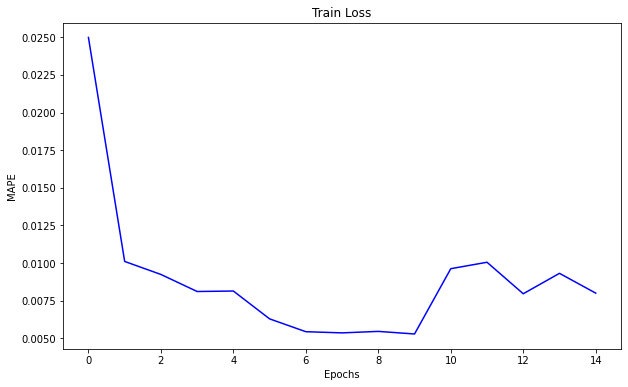

In [ ]:
plt.figure(figsize = (10, 6))

plt.title('Train Loss')
plt.plot(train_loss, 'b-', )
plt.ylabel('MAPE')
plt.xlabel('Epochs')

plt.show()

# **5. HI 계산**

In [ ]:
# 저장된 모델 불러오기
model.load_state_dict(torch.load('./model/model.pt'))

<All keys matched successfully>

In [ ]:
model.eval()

lstm_autoencoder(
  (encoder): lstm_encoder(
    (lstm): LSTM(14, 1, num_layers=2, batch_first=True)
    (fc1): Linear(in_features=20, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=1, bias=True)
  )
  (decoder): decoder(
    (fc1): Linear(in_features=1, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=20, bias=True)
  )
)

In [ ]:
%%time

# HI curve를 구하기 위해 다시 train dataset의 DataLoader 객체를 생성한다.
pred_loader = DataLoader(train_dataset_1, batch_size=1)

HI_trajectory_dataset = np.empty((0, 15))  # HI trajectory modeling 위한 dataset (HI trajectory modeling 수행하지 않음)
HI_trajectory_target = np.empty((0, 2))    # HI trajectory modeling 위한 HI target set

with torch.no_grad():
    for _, x in enumerate(pred_loader):
        input = x[:,:,1:].to(DEVICE).float()
        _, _, HI = model(input) 
        input, HI = input.cpu(), HI.cpu()

        temp = np.append(x[:,-1,0:1], input[:, -1, :].squeeze(1), axis = 1)
        HI_trajectory_dataset = np.append(HI_trajectory_dataset, temp, axis = 0)

        temp = np.append(x[:,-1,0:1], HI.squeeze(0), axis = 1)
        HI_trajectory_target = np.append(HI_trajectory_target, temp, axis = 0)

print(HI_trajectory_dataset.shape, HI_trajectory_target.shape)

(18731, 15) (18731, 2)
CPU times: user 44.2 s, sys: 683 ms, total: 44.9 s
Wall time: 44.7 s


In [ ]:
%%time

HI_test = np.empty((0, 2))

with torch.no_grad():
    for _, x in enumerate(test_loader_1):
        input = x[:,:,1:].to(DEVICE).float()
        _, _, HI = model(input) 
        HI = HI.cpu()

        temp = np.append(x[:,-1,0:1], HI.squeeze(0), axis = 1)
        HI_test = np.append(HI_test, temp, axis = 0)

print(HI_test.shape)

(11196, 2)
CPU times: user 23 s, sys: 153 ms, total: 23.2 s
Wall time: 23.1 s


## **정규화**

In [ ]:
# 각 unit의 HI values를 MinMaxScaling하여 [0,1] 범위로 정규화한다. 
HI_trajectory_target_scaled = np.empty((0, 2))
HI_test_scaled = np.empty((0, 2))

for i in range(1,101):

    temp_train = HI_trajectory_target[HI_trajectory_target[:,0] == i]
    temp_test = HI_test[HI_test[:,0] == i]

    scaler_train = MinMaxScaler().fit(temp_train[:,1:])
    temp_scaled_train = scaler_train.transform(temp_train[:,1:])
    temp_scaled_test = scaler_train.transform(temp_test[:,1:])
    result_train = np.append(temp_train[:,0:1], temp_scaled_train, axis = 1)
    result_test = np.append(temp_test[:,0:1], temp_scaled_test, axis = 1)

    HI_trajectory_target_scaled = np.append(HI_trajectory_target_scaled, result_train, axis = 0)
    HI_test_scaled = np.append(HI_test_scaled, result_test, axis = 0)

print(HI_trajectory_target_scaled.shape, HI_test_scaled.shape)

(18731, 2) (11196, 2)


## **Exponential Smoothing**

In [ ]:
# https://en.wikipedia.org/wiki/Exponential_smoothing
def exponential_smoothing(X, a):
    S = np.zeros(X.shape[0])
    S[0] = X[0]
    for t in range(1,X.shape[0]):
        S[t] = a * X[t-1] + (1-a) * S[t-1]
    return S

In [ ]:
# 센서 기록 시의 노이즈를 완화하기 위해 Exponential Smoothing을 적용한다. 
HI_trajectory_target_scaled_smoothed = np.empty((0, 2))

for i in range(1,101):

    temp = HI_trajectory_target_scaled[HI_trajectory_target_scaled[:,0] == i]
    temp_smoothed = exponential_smoothing(HI_trajectory_target_scaled[HI_trajectory_target_scaled[:,0] == i][:,1], 0.3).reshape(-1, 1)
    result = np.append(temp[:,0:1], temp_smoothed, axis = 1)

    HI_trajectory_target_scaled_smoothed = np.append(HI_trajectory_target_scaled_smoothed, result, axis = 0)

print(HI_trajectory_target_scaled_smoothed.shape)

(18731, 2)


In [ ]:
HI_test_scaled_smoothed = np.empty((0, 2))

for i in range(1,101):

    temp = HI_test_scaled[HI_test_scaled[:,0] == i]
    temp_smoothed = exponential_smoothing(HI_test_scaled[HI_test_scaled[:,0] == i][:,1], 0.3).reshape(-1, 1)
    result = np.append(temp[:,0:1], temp_smoothed, axis = 1)

    HI_test_scaled_smoothed = np.append(HI_test_scaled_smoothed, result, axis = 0)

print(HI_test_scaled_smoothed.shape)

(11196, 2)


## **HI Curve library: offline**

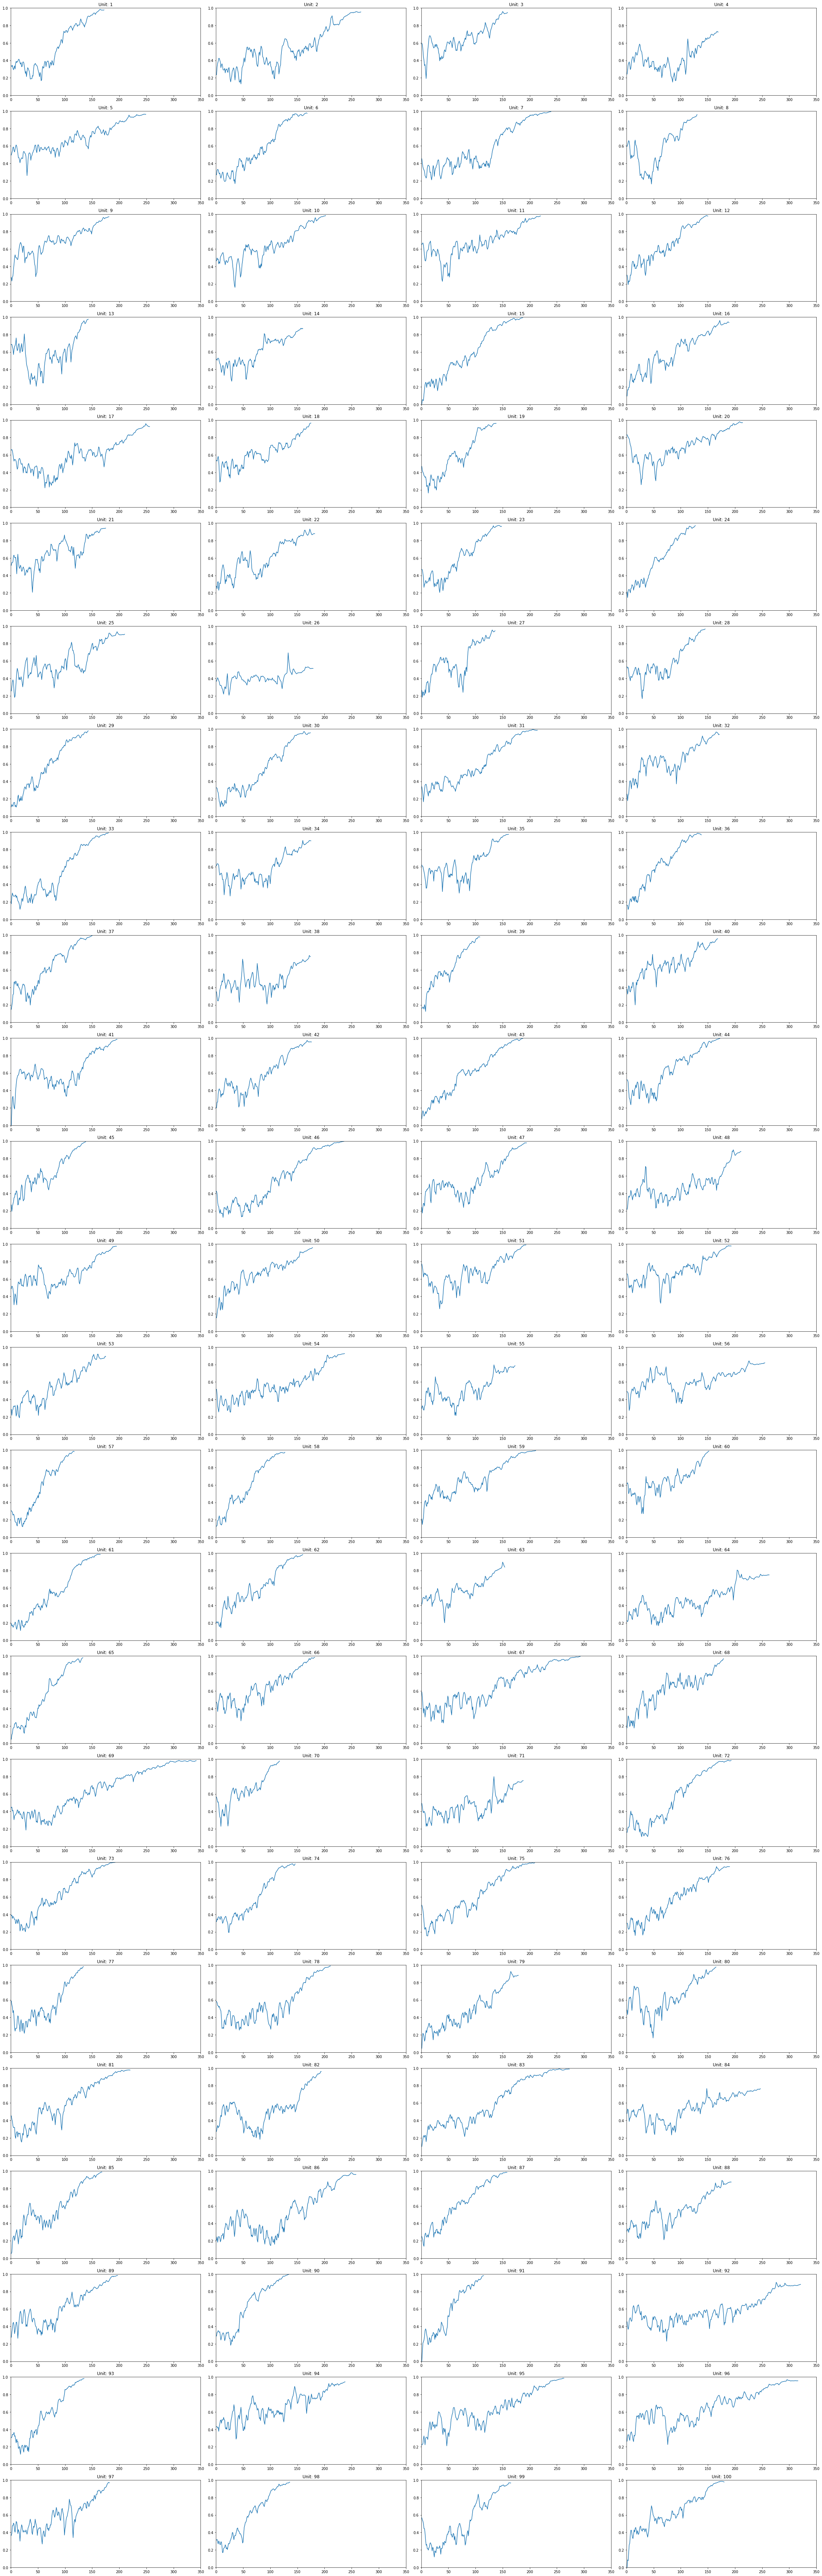

In [ ]:
fig, ax = plt.subplots(figsize=(32,100), nrows = 25, ncols = 4)

for i in range(1, 101):
    temp = HI_trajectory_target_scaled_smoothed[HI_trajectory_target_scaled_smoothed[:,0]==i][:,1]
    r = (i-1) // 4 
    c = (i-1) % 4
    ax[r, c].plot(temp)
    ax[r, c].set_title('Unit: {}'.format(i))
    ax[r, c].set_xlim([0, 350])
    ax[r, c].set_ylim([0, 1])

fig.tight_layout()
plt.show()

## **Test HI curve: online**

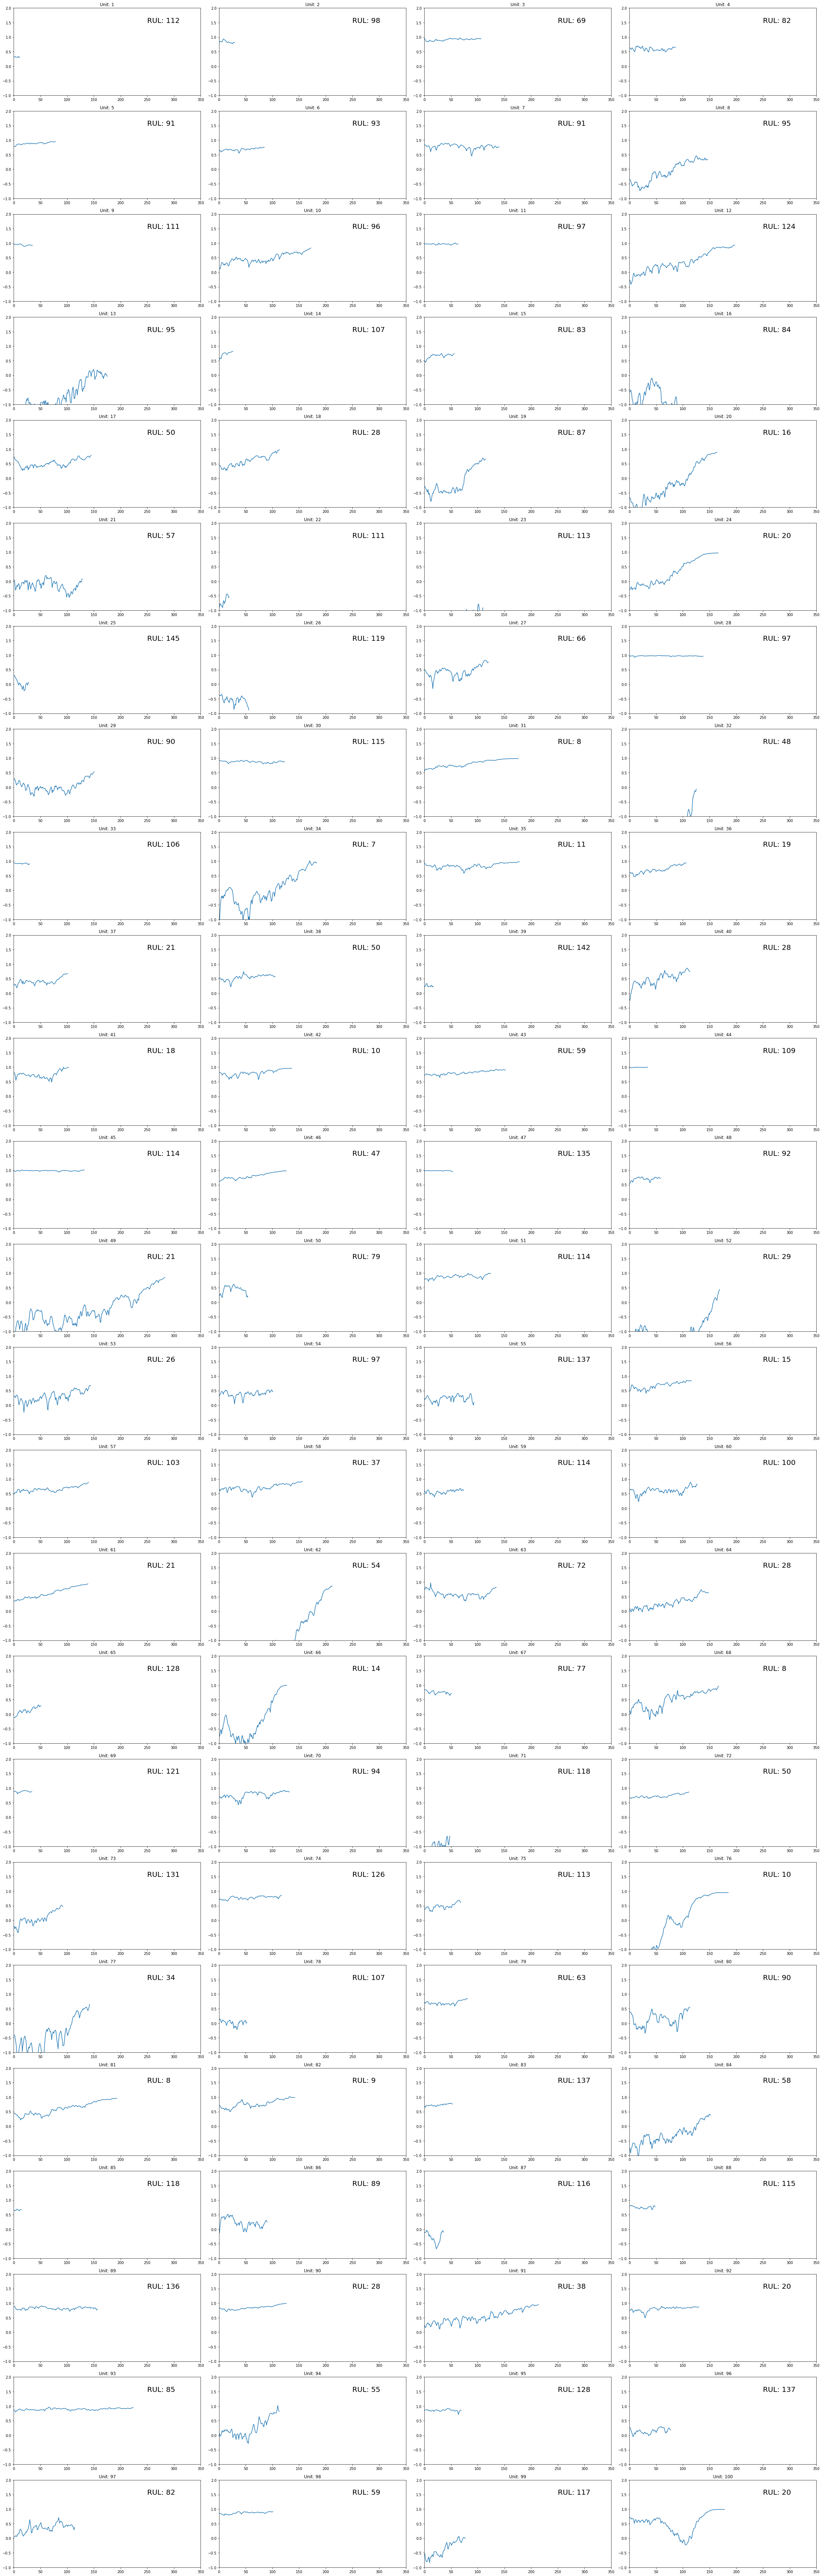

In [ ]:
fig, ax = plt.subplots(figsize=(32,100), nrows = 25, ncols = 4)

for i in range(1, 101):
    temp = HI_test_scaled_smoothed[HI_test_scaled_smoothed[:,0]==i][:,1]
    RUL = test_RUL[i-1]
    r = (i-1) // 4 
    c = (i-1) % 4
    ax[r, c].plot(temp)
    ax[r, c].set_title('Unit: {}'.format(i))
    ax[r, c].text(250, 1.5, 'RUL: %d' % RUL, fontsize = 20)
    ax[r, c].set_xlim([0, 350])
    ax[r, c].set_ylim([-1, 2])

fig.tight_layout()
plt.show()

# **6. RUL 예측**

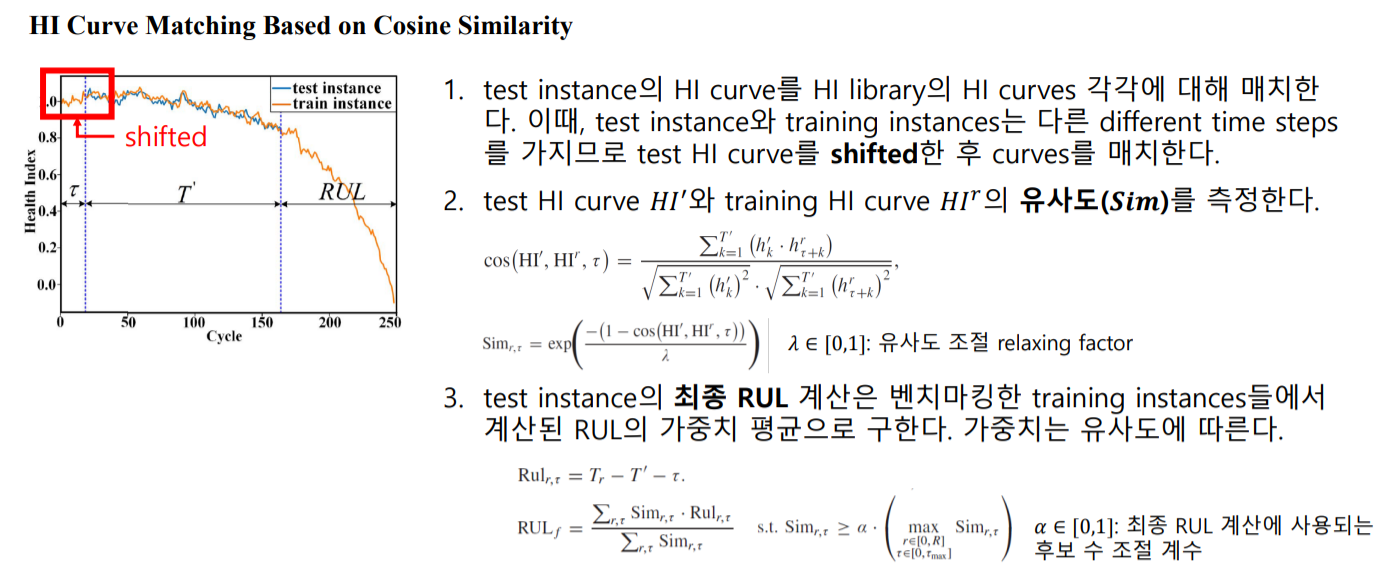

# 내부 구조 변경

*다음과 같이 모델 내부 구조를 일부분 변경하여 훈련해보았습니다. 각각에 대해 모델의 결과가 뚜렷하게 변하는 부분은 없었습니다.*

1. window size = 10
2. batch_size = 64
3. criterion = nn.MSELoss()